In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
% matplotlib inline

c:\Users\adid5\Anaconda3\envs\Project\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
UsageError: Line magic function `%` not found.


# Load Data

In [2]:
# Load activity data
data_phone_act = pd.read_csv('..\..\..\datasets\Human_Activity\data_phone_with_labels_Act.csv')
data_phone_act.drop(['Unnamed: 0'],axis=1,inplace=True)
data_phone_act.head(10)

,source,timestamp,values,activity,index_activity,start_point_activity
0,pressure,2017-06-29 09:57:00.070,['963.3365'],Eat,0.0,2017-06-29 09:57
1,step_detector,2017-06-29 09:57:00.280,['1.0'],Eat,0.0,2017-06-29 09:57
2,audio,2017-06-29 09:57:00.448,"['8513.0', '7546.236', '32767.0', '45.0']",Eat,0.0,2017-06-29 09:57
3,step_detector,2017-06-29 09:57:01.000,['1.0'],Eat,0.0,2017-06-29 09:57
4,gravity,2017-06-29 09:57:01.441,"['2.3287392', '-8.675122', '-3.9356887']",Eat,0.0,2017-06-29 09:57
5,audio,2017-06-29 09:57:01.447,"['8273.0', '7546.3276', '32767.0', '45.0']",Eat,0.0,2017-06-29 09:57
6,step_detector,2017-06-29 09:57:01.521,['1.0'],Eat,0.0,2017-06-29 09:57
7,linear_acceleration,2017-06-29 09:57:01.600,"['3.6848893', '-5.382506', '-1.925926']",Eat,0.0,2017-06-29 09:57
8,rotationVector,2017-06-29 09:57:01.607,"['-0.6266626', '0.5223481', '-0.42348957', '0....",Eat,0.0,2017-06-29 09:57
9,step_detector,2017-06-29 09:57:02.275,['1.0'],Eat,0.0,2017-06-29 09:57


# Util's Function 

In [3]:
# Extract the values of each source from the table 
def Extract_Source(source,data):
    df = data[data['source'] == source].copy(deep=True)
    df.sort_values(by = 'timestamp',inplace=True)
    return df

In [4]:
# Resmaple the data by a given sample rate and apply func on the values column (can be more than one column)
def Group_and_Resample(data,sample,func):
    data['timestamp'] = pd.to_datetime(data['timestamp'])
    
    if 'X' in data.columns:
        data_sample = data.resample(sample, on="timestamp").agg({'X':func,'Y':func,'Z':func, 'index_activity':pd.Series.mode, 'activity':pd.Series.mode})
    elif 'audio_mic_1' in data.columns:
        data_sample = data.resample(sample, on="timestamp").agg({'audio_mic_1':func,'audio_mic_2':func,'audio_mic_3':func,'audio_mic_4':func,'index_activity':pd.Series.mode, 'activity':pd.Series.mode})
    elif func == 'pd.Series.mode':
        data_sample = data.resample(sample, on="timestamp").agg({'values':pd.Series.mode, 'index_activity':pd.Series.mode, 'activity':pd.Series.mode})
    else:
        data_sample = data.resample(sample, on="timestamp").agg({'values':func, 'index_activity':pd.Series.mode, 'activity':pd.Series.mode})
     
    return data_sample

In [5]:
# Remove Nan rows from the table
def RemoveNan(data):
    data = data[data['index_activity'].apply(type) != np.ndarray]
    return data

In [6]:
data_phone_act['source'].unique()

array(['pressure', 'step_detector', 'audio', 'gravity',
       'linear_acceleration', 'rotationVector', 'orientation',
       'accelerometer', 'gyroscope', 'magnetometer', 'activity',
       'step_counter', 'light', 'wifi', 'bluetooth', 'battery',
       'proximity'], dtype=object)

## Parameters

In [7]:
sample = '30S'

## Feature Engineering 

### Pressure

In [8]:
pressureData = Extract_Source('pressure',data_phone_act)
# remove [''] from each value
pressureData['values'] = pressureData['values'].apply(lambda x: np.double(x[2:-2]))
pressureData_sample = Group_and_Resample(pressureData, sample,'mean')
pressureData_sample.rename(columns = {'values':'pressure'},inplace = True)
final_pressureData = RemoveNan(pressureData_sample)

### Step Detector

In [9]:
step_detectorData = Extract_Source('step_detector',data_phone_act)
step_detectorData['values'] = step_detectorData['values'].apply(lambda x: np.double(x[2:-2])).astype(int)
step_detectorData_sample = Group_and_Resample(step_detectorData, sample,'pd.Series.mode')
step_detectorData_sample.rename(columns = {'values':'step_detector'},inplace = True)
final_stepDetectorData = RemoveNan(step_detectorData_sample)

### Audio 

In [10]:
audioData = Extract_Source('audio',data_phone_act)
audioData['values'] = audioData['values'].apply(lambda x: x.split(','))
audioData['audio_mic_1'] = audioData['values'].apply(lambda x: np.double(x[0][2:-1]))
audioData['audio_mic_2'] = audioData['values'].apply(lambda x: np.double(x[1][2:-1]))
audioData['audio_mic_3'] = audioData['values'].apply(lambda x: np.double(x[2][2:-2])) # mic 3 have saturated values 
audioData['audio_mic_4'] = audioData['values'].apply(lambda x: np.double(x[3][2:-2])) # mic 4 have low values 
audioData_sample = Group_and_Resample(audioData, sample,'mean')
final_audioData = RemoveNan(audioData_sample)

### Gravity

In [11]:
gravityData = Extract_Source('gravity',data_phone_act)
gravityData['values'] = gravityData['values'].apply(lambda x: x.split(',')) # split to X,Y,Z
gravityData['X'] = gravityData['values'].apply(lambda x: np.double(x[0][2:-1]))
gravityData['Y'] = gravityData['values'].apply(lambda x: np.double(x[1][2:-1]))
gravityData['Z'] = gravityData['values'].apply(lambda x: np.double(x[2][2:-2]))
gravityData_sample = Group_and_Resample(gravityData, sample,'mean')
gravityData_sample['values'] = np.sqrt(np.power(gravityData_sample['X'],2)+np.power(gravityData_sample['Y'],2)+np.power(gravityData_sample['Z'],2)) # Gravity  = sqrt(X^2+Y^2+Z^2)
gravityData_sample.rename(columns = {'values':'gravity'},inplace = True)
gravityData_sample.drop(['X','Y','Z'],axis=1,inplace=True)
final_gravityData = RemoveNan(gravityData_sample)

### Linear Acceleration

In [12]:
linear_accelerationData = Extract_Source('linear_acceleration',data_phone_act)
linear_accelerationData['values'] = linear_accelerationData['values'].apply(lambda x: x.split(','))
linear_accelerationData['X'] = linear_accelerationData['values'].apply(lambda x: np.double(x[0][2:-1]))
linear_accelerationData['Y'] = linear_accelerationData['values'].apply(lambda x: np.double(x[1][2:-1]))
linear_accelerationData['Z'] = linear_accelerationData['values'].apply(lambda x: np.double(x[2][2:-2]))
linear_accelerationData_sample = Group_and_Resample(linear_accelerationData, sample,'mean')
linear_accelerationData_sample.rename(columns = {'values':'linear_acceleration'},inplace = True)
# linear acceleration = sqrt(X^2+Y^2+Z^2)
linear_accelerationData_sample['values'] = np.sqrt(np.power(linear_accelerationData_sample['X'],2)+np.power(linear_accelerationData_sample['Y'],2)+np.power(linear_accelerationData_sample['Z'],2))
linear_accelerationData_sample.rename(columns = {'values':'linear_acceleration'},inplace = True)
linear_accelerationData_sample.drop(['X','Y','Z'],axis=1,inplace=True)
final_linearAccelerationData = RemoveNan(linear_accelerationData_sample)

### Rotation Vector

In [13]:
rotationVectorData = Extract_Source('rotationVector',data_phone_act)
# Do not use

### Orientation

In [14]:
orientationData = Extract_Source('orientation',data_phone_act)
orientationData['values'] = orientationData['values'].apply(lambda x: x.split(','))
orientationData['X'] = orientationData['values'].apply(lambda x: np.double(x[0][2:-1]))
orientationData['Y'] = orientationData['values'].apply(lambda x: np.double(x[1][2:-1]))
orientationData['Z'] = orientationData['values'].apply(lambda x: np.double(x[2][2:-2]))
orientationData_sample = Group_and_Resample(orientationData, sample,'mean')
orientationData_sample.rename(columns = {'X':'orientation_X','Y':'orientation_Y','Z':'orientation_Z'},inplace = True)
final_orientationData = RemoveNan(orientationData_sample)

### Accelerometer

In [15]:
accelerometerData = Extract_Source('accelerometer',data_phone_act)
accelerometerData['values'] = accelerometerData['values'].apply(lambda x: x.split(','))
accelerometerData['X'] = accelerometerData['values'].apply(lambda x: np.double(x[0][2:-1]))
accelerometerData['Y'] = accelerometerData['values'].apply(lambda x: np.double(x[1][2:-1]))
accelerometerData['Z'] = accelerometerData['values'].apply(lambda x: np.double(x[2][2:-2]))
accelerometerData_sample = Group_and_Resample(accelerometerData, sample,'mean')
accelerometerData_sample.rename(columns = {'X':'accelerometer_X','Y':'accelerometer_Y','Z':'accelerometer_Z'},inplace = True)
final_accelerometerData = RemoveNan(accelerometerData_sample)

### Gyroscope

In [16]:
gyroscopeData = Extract_Source('gyroscope',data_phone_act)
gyroscopeData['values'] = gyroscopeData['values'].apply(lambda x: x.split(','))
gyroscopeData['X'] = gyroscopeData['values'].apply(lambda x: np.double(x[0][2:-1]))
gyroscopeData['Y'] = gyroscopeData['values'].apply(lambda x: np.double(x[1][2:-1]))
gyroscopeData['Z'] = gyroscopeData['values'].apply(lambda x: np.double(x[2][2:-2]))
gyroscopeData_sample = Group_and_Resample(gyroscopeData, sample,'mean')
gyroscopeData_sample.rename(columns = {'X':'gyroscope_X','Y':'gyroscope_Y','Z':'gyroscope_Z'},inplace = True)
final_gyroscopeData = RemoveNan(gyroscopeData_sample)

### Magnetometer

In [17]:
magnetometerData = Extract_Source('magnetometer',data_phone_act)
magnetometerData['values'] = magnetometerData['values'].apply(lambda x: x.split(','))
magnetometerData['X'] = magnetometerData['values'].apply(lambda x: np.double(x[0][2:-1]))
magnetometerData['Y'] = magnetometerData['values'].apply(lambda x: np.double(x[1][2:-1]))
magnetometerData['Z'] = magnetometerData['values'].apply(lambda x: np.double(x[2][2:-2]))
magnetometerData_sample = Group_and_Resample(magnetometerData, sample,'mean')
magnetometerData_sample.rename(columns = {'X':'magnetometer_X','Y':'magnetometer_Y','Z':'magnetometer_Z'},inplace = True)
final_magnetometerData = RemoveNan(magnetometerData_sample)

### Activity

In [18]:
activityData = Extract_Source('activity',data_phone_act)
# DO NOT USE 

### Step Counter

In [19]:
step_counterData = Extract_Source('step_counter',data_phone_act)
step_counterData['values'] = step_counterData['values'].apply(lambda x: np.double(x[2:-2])).astype(int)
step_counterData_sample = Group_and_Resample(step_counterData, sample,'sum')
step_counterData_sample.rename(columns = {'values':'step_counter'},inplace = True)
final_stepCounterData = RemoveNan(step_counterData_sample)

### Light

In [20]:
lightData = Extract_Source('light',data_phone_act)
lightData['values']= lightData['values'].apply(lambda x: np.double(x[2:-2])).astype(int)
lightData_sample = Group_and_Resample(lightData, sample,'mean')
lightData_sample.rename(columns = {'values':'light'},inplace = True)
final_lightData = RemoveNan(lightData_sample)

### Wifi

In [21]:
wifiData = Extract_Source('wifi',data_phone_act)
wifiData['values'] = wifiData['values'].str.split(',').apply(len)
wifiData_sample = Group_and_Resample(wifiData, sample,'mean')
wifiData_sample.rename(columns = {'values':'number_of_devices_wifi'},inplace = True)
final_wifiData = RemoveNan(wifiData_sample)
final_wifiData['number_of_devices_wifi'] = final_wifiData['number_of_devices_wifi'].apply(int)

<ipython-input-21-04563c4a450e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_wifiData['number_of_devices_wifi'] = final_wifiData['number_of_devices_wifi'].apply(int)


### Bluetooth

In [22]:
bluetoothData = Extract_Source('bluetooth',data_phone_act)
bluetoothData['values'] = bluetoothData['values'].str.split(',').apply(len)
bluetoothData_sample = Group_and_Resample(bluetoothData, sample,'mean')
bluetoothData_sample.rename(columns = {'values':'bluetooth'},inplace = True)
final_bluetoothData = RemoveNan(bluetoothData_sample)
final_bluetoothData['bluetooth'] = final_bluetoothData['bluetooth'].apply(int)

<ipython-input-22-1e2d9e9c49fa>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_bluetoothData['bluetooth'] = final_bluetoothData['bluetooth'].apply(int)


### Battery

In [23]:
batData = Extract_Source('battery',data_phone_act)
batData['values'] = batData['values'].apply(lambda x: int(x[2:-2]))
batData_sample = Group_and_Resample(batData, sample,'mean')
batData_sample.rename(columns = {'values':'battery'},inplace = True)
final_batData = RemoveNan(batData_sample)

### Proximity

In [24]:
proximityData = Extract_Source('proximity',data_phone_act)
proximityData['values'].unique()
# Do Not Use
# there was only 5 and 0 values

array(["['5.0']", "['0.0']"], dtype=object)

## Merge

In [25]:
from functools import reduce
df = [final_pressureData,final_stepDetectorData,final_audioData,final_gravityData,final_linearAccelerationData,
final_orientationData,final_accelerometerData,final_gyroscopeData,final_magnetometerData,final_stepCounterData,final_lightData,
final_wifiData,final_batData,final_bluetoothData]

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['timestamp','activity','index_activity'],
                                            how='outer'), df)
df_merged.sort_values(by = 'timestamp',inplace=True)
df_merged.reset_index(inplace=True)
df_merged.to_csv('..\..\..\datasets\Human_Activity\FullDataAct.csv')

<AxesSubplot:>

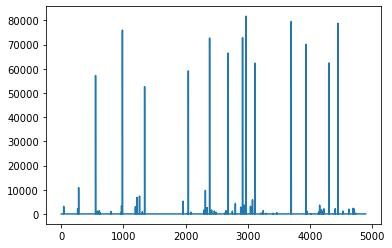

In [26]:
# Check how continus the data is in terms of timestamp
diffTime = df_merged['timestamp'].diff()
diffTimeSec = diffTime.dt.total_seconds()
diffTimeSec.plot()

## Fill Nan

<AxesSubplot:>

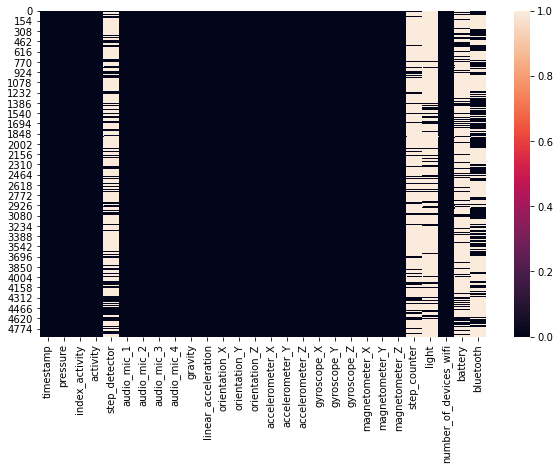

In [27]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.isnull(df_merged).astype(int))

In [28]:
# Checking how many Nans there are in each feature
print('step_detector percentage of nan:',df_merged['step_detector'].isna().sum() / len(df_merged))
print('step_counter  percentage of nan:',df_merged['step_counter'].isna().sum() / len(df_merged))
print('light         percentage of nan:',df_merged['light'].isna().sum() / len(df_merged))
print('battery       percentage of nan:',df_merged['battery'].isna().sum() / len(df_merged))
print('bluetooth     percentage of nan:',df_merged['bluetooth'].isna().sum() / len(df_merged))

step_detector percentage of nan: 0.6693894220951603
step_counter  percentage of nan: 0.8260159281192567
light         percentage of nan: 0.8572595466612212
battery       percentage of nan: 0.7081886869511946
bluetooth     percentage of nan: 0.5458443945272616


In [29]:
# Delete features with more than 80% nan values
df_merged.drop(['step_counter','light'],axis=1,inplace=True)

<AxesSubplot:>

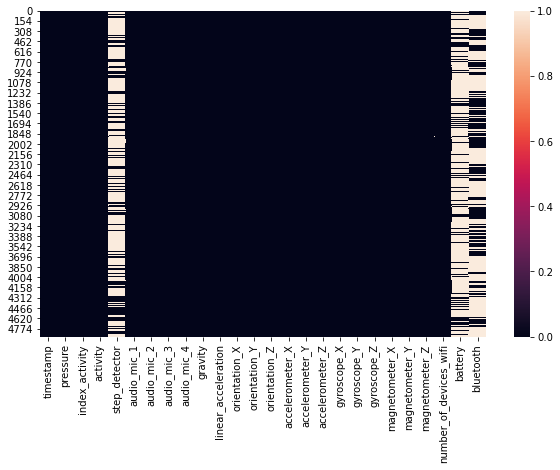

In [30]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.isnull(df_merged).astype(int))

In [31]:
# Fill nan of step_detector with zero 
df_merged['step_detector'].fillna(0,inplace = True)
df_merged['step_detector']

0       1
1       1
2       1
3       1
4       1
       ..
4892    0
4893    0
4894    0
4895    0
4896    0
Name: step_detector, Length: 4897, dtype: int64

<AxesSubplot:>

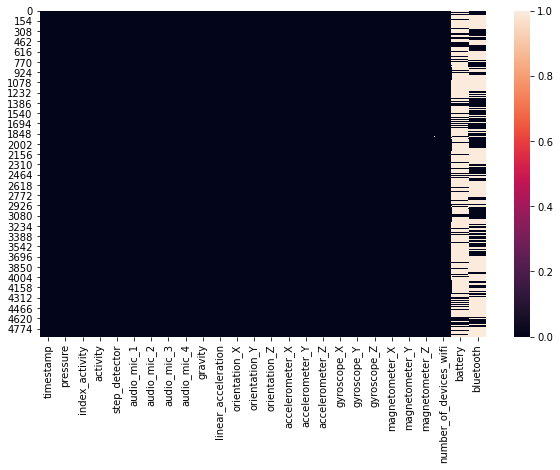

In [32]:
plt.figure(figsize=(10,6))
sns.heatmap(pd.isnull(df_merged).astype(int))

In [33]:
BluMean = int(df_merged['bluetooth'].mean())
df_merged['diffTimeSec'] = diffTimeSec # add the diff between the rows timestamp for checking what is the gap between two consecutive rows
# This function fill the nan values of the bluetooth
# for each row we check if the value is nan and if the gap between this row to the previus row is smaller than two sample rate (60 s) 
# if so we fill the nan by the previus value 
# elif the value is nan and the gap is bigger than 2 sample rate, we fill the nan by the int mean value of the bluetooth
def fillFunc(x):
    bluetooth = x.bluetooth
    diffTimeSec = x.diffTimeSec
    name = x.name    
    if np.isnan(bluetooth) and diffTimeSec < 61:
        x.bluetooth = df_merged.loc[name-1,'bluetooth']
    elif np.isnan(bluetooth):
        x.bluetooth = BluMean
    return x

In [34]:
for index,row in df_merged.iterrows():
    df_merged.iloc[index] = fillFunc(row)

In [35]:
inter_df_merged = df_merged.copy(deep = True) # for comparison between before interpolation and after intrpolation we made copy of the table

In [36]:
# We applyed a linear intepolation for the battery data points
inter_df_merged['battery'] = inter_df_merged['battery'].interpolate()

Text(0, 0.5, 'battery')

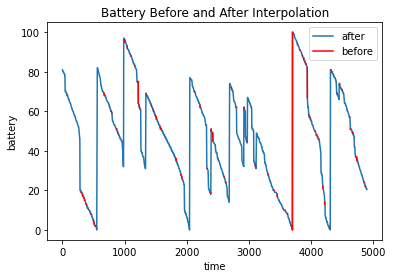

In [37]:
inter_df_merged['battery'].plot()
df_merged['battery'].plot(c = 'r')
plt.legend(['after','before'])
plt.title('Battery Before and After Interpolation')
plt.xlabel('time')
plt.ylabel('battery')

Text(0, 0.5, 'battery')

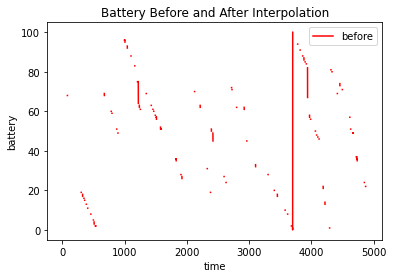

In [38]:
df_merged['battery'].plot(c= 'r')
plt.legend(['before'])
plt.title('Battery Before and After Interpolation')
plt.xlabel('time')
plt.ylabel('battery')

17


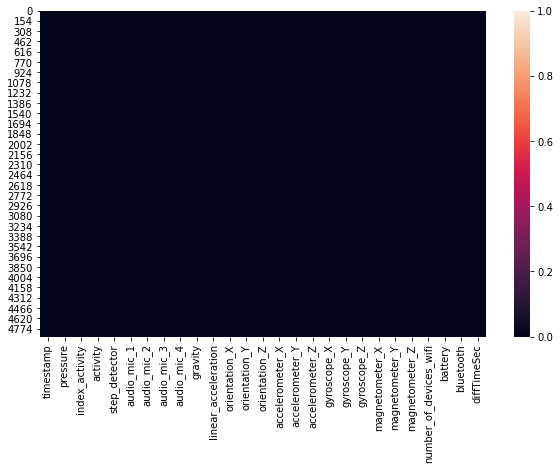

In [39]:
# Check that we have no nan in the final table
plt.figure(figsize=(10,6))
sns.heatmap(pd.isnull(inter_df_merged).astype(int))
print(inter_df_merged.isna().sum().sum())

In [40]:
# Drop the remain nan values 
NanIdx = np.where(inter_df_merged.isna())
np.unique(NanIdx[0])
inter_df_merged.drop(np.unique(NanIdx[0]),inplace=True)
print(inter_df_merged.isna().sum().sum())

0


In [41]:
inter_df_merged.head(10)

,timestamp,pressure,index_activity,activity,step_detector,audio_mic_1,audio_mic_2,audio_mic_3,audio_mic_4,gravity,...,gyroscope_X,gyroscope_Y,gyroscope_Z,magnetometer_X,magnetometer_Y,magnetometer_Z,number_of_devices_wifi,battery,bluetooth,diffTimeSec
1,2017-06-29 09:57:30,963.210350,0.0,Eat,1,11927.200000,7563.650340,32767.0,45.0,9.428560,...,-0.150097,-0.568192,0.018634,-34.885090,-10.494576,7.990740,46.0,81.0,2.0,30.0
2,2017-06-29 09:58:00,963.377710,0.0,Eat,1,9694.366667,7582.004297,32767.0,45.0,9.495720,...,0.216265,-0.180258,-0.001961,-27.762173,-9.277909,-3.415510,56.0,80.8,2.0,30.0
3,2017-06-29 09:58:30,963.352867,0.0,Eat,1,7590.000000,7579.942257,32767.0,45.0,9.548030,...,-0.167142,-0.142885,-0.176842,-23.574674,-13.215409,18.199073,57.0,80.6,2.0,30.0
4,2017-06-29 09:59:00,963.356162,0.0,Eat,1,11810.733333,7589.977663,32767.0,45.0,9.502039,...,-0.032652,-0.428465,-0.343290,-11.147591,-8.746659,-4.144677,55.0,80.4,2.0,30.0
5,2017-06-29 09:59:30,963.335040,0.0,Eat,1,7881.866667,7600.249840,32767.0,45.0,9.609119,...,-0.220582,-0.562955,-0.174356,-15.189257,-5.423743,-9.175927,55.0,80.2,4.0,30.0
6,2017-06-29 10:00:00,963.346502,0.0,Eat,1,12377.733333,7606.813603,32767.0,45.0,9.368099,...,-0.670213,0.465913,-0.788126,-18.689257,-5.059160,27.751157,61.0,80.0,2.0,30.0
7,2017-06-29 10:00:30,963.392575,0.0,Eat,1,10225.166667,7622.846237,32767.0,45.0,9.477471,...,0.771889,-0.534459,0.312913,-13.824675,-7.090409,23.449073,61.0,80.0,1.0,30.0
8,2017-06-29 10:01:00,963.333287,0.0,Eat,1,9992.400000,7629.055077,32767.0,45.0,9.688910,...,0.215555,0.046377,0.262846,-16.793425,-4.121659,33.990740,59.0,80.0,2.0,30.0
9,2017-06-29 10:01:30,963.332382,0.0,Eat,1,6361.866667,7633.940360,32767.0,45.0,9.775084,...,0.031086,0.046199,0.008958,-19.605923,14.992924,31.188657,60.0,80.0,3.0,30.0
10,2017-06-29 10:02:00,963.388735,0.0,Eat,1,11049.266667,7635.660040,32767.0,45.0,9.366269,...,0.413427,-0.250566,-0.113281,-15.230255,-8.953069,21.923894,62.0,80.0,3.0,30.0


In [42]:
inter_df_merged.sort_values(by = 'timestamp',inplace=True)
inter_df_merged.reset_index(inplace=True)
inter_df_merged.to_csv(f'..\..\..\datasets\Human_Activity\FinalFullDataAct_sampleRtate_{sample}.csv')